<a href="https://colab.research.google.com/github/0902338471/GMM-CinnamonAI/blob/master/GMM_CinnamonAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [214]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import necessary libraries and tools**

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.io 

In [0]:
root_path = "/content/drive/My Drive/CinnamonAI/Gaussian-Model/"

In [0]:
#loading data and split X,y features.
data = scipy.io.loadmat(root_path+"cardio.mat")
X = data["X"]
y= data["y"]

**Splitting Dataset**

In [0]:
df = pd.DataFrame(X)
df['normal_label']=y

In [219]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,normal_label
0,0.004912,0.693191,-0.203640,0.595322,0.353190,-0.061401,-0.278295,-1.650444,0.759072,-0.420487,0.372149,1.485973,-0.798376,1.854728,0.622631,0.963083,0.301464,0.193113,0.231498,-0.289786,-0.493294,0.0
1,0.110729,-0.079903,-0.203640,1.268942,0.396246,-0.061401,-0.278295,-1.710270,0.759072,-0.420487,0.882794,1.485973,-0.798376,1.854728,0.278625,0.963083,0.301464,0.129265,0.093563,-0.256385,-0.493294,0.0
2,0.216546,-0.272445,-0.203640,1.050988,0.148753,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,2.516859,1.141780,-1.332931,0.314688,2.342663,-0.488279,0.061002,0.065417,0.024596,-0.256385,1.140018,0.0
3,0.004912,0.727346,-0.203640,1.212171,-0.683598,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,1.989193,1.141780,-1.332931,0.314688,1.654650,-0.488279,0.061002,0.193113,0.093563,-0.323186,1.140018,0.0
4,-0.100905,0.363595,1.321366,1.027120,0.141359,-0.061401,-0.278295,-0.992364,-0.051613,-0.420487,0.797687,-0.208514,-0.085638,-0.565334,0.278625,-0.488279,-0.059229,0.065417,0.024596,-0.456787,1.140018,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1826,-0.418356,-0.919988,-0.161178,0.829564,0.953023,-0.061401,3.060819,1.221178,1.338133,-0.420487,-1.398088,1.459497,-0.976561,1.524719,0.622631,-0.488279,-1.982928,-2.616202,-1.561651,0.244620,-0.493294,1.0
1827,-0.418356,-0.919988,-0.171055,0.796630,0.823510,-0.061401,3.565299,1.281003,1.453945,-0.420487,-1.398088,1.459497,-0.976561,1.524719,-0.065382,-0.488279,-1.862696,-2.807747,-1.699585,0.010817,-0.493294,1.0
1828,-0.418356,-0.919988,-0.164635,0.952396,1.120470,-0.061401,2.788995,1.221178,1.222321,-0.420487,-1.398088,1.459497,-0.976561,1.524719,0.622631,-0.488279,-1.922812,-2.488506,-1.492683,0.244620,-0.493294,1.0
1829,-0.418356,-0.919988,-0.150934,0.695726,1.212428,-0.061401,2.484822,1.221178,1.222321,-0.420487,-1.398088,1.459497,-0.976561,1.524719,0.278625,-0.488279,-1.321656,-2.296962,-1.423716,0.144419,-0.493294,1.0


In [0]:
X_train = df[df['normal_label']==0].drop(labels='normal_label',axis=1).to_numpy()

**Visulizing and selecting two random features of X_train**

In [0]:
X_train_candidate_features = X_train[:,2:4]
X_train_candidate_features = pd.DataFrame(X_train_candidate_features)

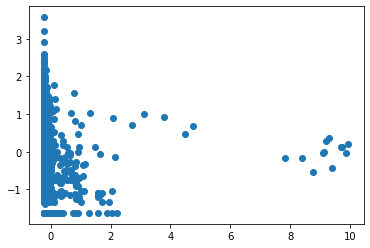

In [222]:
plt.scatter(X_train_candidate_features[0],X_train_candidate_features[1])

**GMM-sklearn**

In [0]:
from sklearn.mixture import GaussianMixture

In [224]:
gmm = GaussianMixture(n_components=3)
gmm.fit(X_train_candidate_features)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [0]:
labels = gmm.predict(X_train_candidate_features) 
X_train_candidate_features['labels']= labels
d0 = X_train_candidate_features[X_train_candidate_features['labels']== 0] 
d1 = X_train_candidate_features[X_train_candidate_features['labels']== 1]
d2 = X_train_candidate_features[X_train_candidate_features['labels']== 2] 

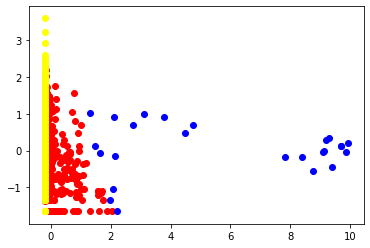

In [226]:
plt.scatter(d0[0], d0[1], c ='r') 
plt.scatter(d1[0], d1[1], c ='yellow') 
plt.scatter(d2[0], d2[1], c ='b') 


**GMM Scratch**

In [0]:
from scipy.stats import multivariate_normal 
import copy

In [0]:
class GMM_Model:
  def __init__(self,num_clusters):
    self.num_clusters = num_clusters

  def init_clusters(self,X):
    #naive initialization of clusters(random generating):
    clusters = []
    coefficient_sum = 0.0
    for i in range(self.num_clusters):
      tmp_cluster = {}
      tmp_cluster['clusters_mean'] = np.random.randn(self.num_features)
      #simple steps to provide positive semi-definite covariance matrix
      tmp_matrix = np.random.randn(self.num_features,self.num_features)
      tmp_cluster['clusters_covariance'] = np.dot(tmp_matrix, np.transpose(tmp_matrix))
      tmp_cluster['clusters_coefficient'] = abs(np.random.randn())
      coefficient_sum += tmp_cluster['clusters_coefficient']
      clusters.append(copy.copy(tmp_cluster))
    #ensuring sum of clusters_coefficient equals to one
    for cluster in clusters:
      cluster['clusters_coefficient'] /= coefficient_sum
    return clusters

  def gaussian_distribution(self,x,mean_var,covariance_var):
    return multivariate_normal.pdf(x,mean=mean_var,cov=covariance_var,allow_singular=True)
  def evaluate_all_responsibilities(self,clusters,X):
    respons_matrix = []
    for example in X:
      total_score = 0.0
      prob_array = []
      for cluster in clusters:
        score = cluster['clusters_coefficient']*self.gaussian_distribution(example,cluster['clusters_mean'],cluster['clusters_covariance'])
        total_score += score
        prob_array.append(score)
      prob_array = prob_array/total_score
      respons_matrix.append(copy.copy(prob_array))
    return respons_matrix
  def covariance_matrix(self,cluster,X):
    cova_matrix_list = []
    for example in X:
      cova_matrix = (example-cluster['clusters_mean']).reshape(self.num_features,1)*(example-cluster['clusters_mean']).reshape(1,self.num_features)
      cova_matrix_list.append(copy.copy(cova_matrix))
    return cova_matrix_list
  def estimate_params(self,clusters,X,respons_matrix):
    for index_cluster,cluster in enumerate(clusters):
      weight_cluster = np.transpose(respons_matrix)[index_cluster]
      new_mean = np.average(X, weights=weight_cluster,axis=0)
      clusters[index_cluster]['clusters_mean'] = copy.copy(new_mean)
      cova_matrix_list = self.covariance_matrix(clusters[index_cluster],X)
      new_covariance = np.average(cova_matrix_list,weights=weight_cluster,axis=0)
      new_coefficient = np.sum(weight_cluster)/self.num_examples
      clusters[index_cluster]['clusters_covariance'] = copy.copy(new_covariance)
      clusters[index_cluster]['clusters_coefficient'] = copy.copy(new_coefficient)
    return clusters
  def evaluate_log_likelihood(self,clusters,X,respons_matrix):
    matrix_score = np.zeros((self.num_examples,self.num_clusters))
    for index_example,example in enumerate(X):
      for index_cluster,cluster in enumerate(clusters):
        matrix_score[index_example][index_cluster] = cluster['clusters_coefficient']*self.gaussian_distribution(example,cluster['clusters_mean'],cluster['clusters_covariance'])
    final_score = np.sum(np.log(np.sum(matrix_score,axis=1)))
    print("Score:",final_score)
  def fit(self,X,num_steps):
    self.num_features = len(X[0])
    self.num_examples = len(X)
    #initialize parameters
    clusters = self.init_clusters(X)
    #EM process
    self.num_steps = num_steps
    for i in range(self.num_steps):
      print("Step ",i+1)
      #calculate responsibilities
      respons_matrix = self.evaluate_all_responsibilities(clusters,X)
      #re-estimate parameters
      clusters = self.estimate_params(clusters,X,respons_matrix)
      #evaluate log-likelihood function
      current_score = self.evaluate_log_likelihood(clusters,X,respons_matrix)
    return clusters
  def predict_class(self,X,clusters):
    label = []
    respons_matrix = self.evaluate_all_responsibilities(clusters,X)
    for example_score in respons_matrix:
      label.append(np.argmax(example_score))
    return label
  def produce_threshold(self,X,clusters):
    respons_matrix = self.evaluate_all_responsibilities(clusters,X)
    #returning min of respons_matrix as threshold for predicting abnormal data
    return np.min(np.asarray(respons_matrix))
  def calculating_score(self,x,clusters):
    respons_matrix = self.evaluate_all_responsibilities(clusters,[x])
    return np.max(np.asarray(respons_matrix))
  def predict_abnormal(self,example,clusters,thresh_hold):
    score = self.calculating_score(example,clusters)
    return score<thresh_hold


**Fix two random features**

In [0]:
gaussian_model = GMM_Model(num_clusters=3)

In [233]:
X_fit = X_train_candidate_features.to_numpy()
clusters = gaussian_model.fit(X_fit,num_steps=20)

Step  1
Score: -1176.7816458308812
Step  2
Score: -2412.3298786667438
Step  3
Score: -3624.598626832062
Step  4
Score: -1395.058581611953
Step  5
Score: -717.3400167481157
Step  6
Score: 592.2749940755369
Step  7
Score: 559.4960084030809
Step  8
Score: 1829.6923119468202
Step  9
Score: 2864.5623496410385
Step  10
Score: 9965.056736008895
Step  11
Score: -2259.764482368206
Step  12
Score: -3250.689321595699
Step  13
Score: -1184.0200268260796
Step  14
Score: -543.6277616105968
Step  15
Score: -190.35498720870936
Step  16
Score: 225.42674309702795
Step  17
Score: 602.5147312634116
Step  18
Score: 1096.4414814131308
Step  19
Score: 1832.2280189587955
Step  20
Score: 3276.6591727921686


In [0]:
#clustering X_fit
labels = gaussian_model.predict_class(X_fit,clusters) 
X_fit = pd.DataFrame(X_fit)
X_fit['labels']= labels
d4 = X_fit[X_fit['labels']== 0] 
d5 = X_fit[X_fit['labels']== 1]
d6 = X_fit[X_fit['labels']== 2] 

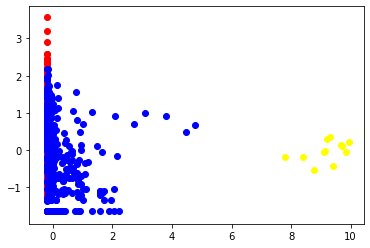

In [235]:
plt.scatter(d4[0], d4[1], c ='r') 
plt.scatter(d5[0], d5[1], c ='yellow') 
plt.scatter(d6[0], d6[1], c='blue')

**Fix all features**

In [0]:
gaussian_model = GMM_Model(num_clusters=3)

In [237]:
X_fit_all = X_train
clusters_all_features = gaussian_model.fit(X_fit_all,num_steps=20)

Step  1
Score: -27788.556436084054
Step  2
Score: -26560.859162121295
Step  3
Score: -24881.27326779558
Step  4
Score: -23026.243001897747
Step  5
Score: -23554.29175684535
Step  6
Score: -22676.555279163713
Step  7
Score: -22440.886908853114
Step  8
Score: -22015.007012440547
Step  9
Score: -21657.966222622315
Step  10
Score: -21271.07884225755
Step  11
Score: -21074.74614463438
Step  12
Score: -20744.32247180477
Step  13
Score: -20119.893144198133
Step  14
Score: -13083.264832387282
Step  15
Score: -20072.907226960357
Step  16
Score: -10885.82633097117
Step  17
Score: -20660.038183325865
Step  18
Score: -18580.443695736976
Step  19
Score: -17297.440718520716
Step  20
Score: -18381.819671888945


**Predict anomalies(all features)**

In [0]:
#predict anomalies
X_test = df[df['normal_label']==1].drop(labels='normal_label',axis=1).to_numpy()

In [0]:
count = 0
cur_thresh_hold = gaussian_model.produce_threshold(X_train,clusters_all_features)
for example in X_test:
  result = gaussian_model.predict_abnormal(example,clusters_all_features,cur_thresh_hold)
  if(result == True):
    count+=1